# Recommendation Using KNN algorithm

In [6]:
import os
import pandas as pd

# read data
data_path = 'C:\\Users\\suraj\\Documents\\Recommendation'
visitor_filename = 'Visitor-2020-09-03.csv'
ratings_filename = 'LocationReview-2020-09-03.csv'
location_filname='Location-2020-09-03.csv'

In [7]:
os.getcwd()

'C:\\Users\\suraj\\Documents\\Recommendation'

In [8]:
# read data
df_visitor = pd.read_csv(
    os.path.join(data_path, visitor_filename),

    usecols=['user'],
    dtype={'user': 'int32'})

df_ratings = pd.read_csv(
    os.path.join(data_path, ratings_filename),
    usecols=['commenter', 'location', 'rating'],
    dtype={'commenter': 'int32', 'location': 'int32', 'rating': 'float32'})

df_location = pd.read_csv(
    os.path.join(data_path,location_filname),

    usecols=['id','title'],
    dtype={'id': 'int32','title':'str'})



In [9]:
df_visitor.head()
df_visitor.shape


(59, 1)

In [10]:
df_ratings.head()


,location,commenter,rating
0,7,65,5.0
1,4,65,5.0
2,8,64,5.0
3,3,64,5.0
4,2,64,4.0


In [11]:
df_ratings.shape

(157, 3)

In [12]:
from scipy.sparse import csr_matrix
# pivot ratings into movie features
df_location_features = df_ratings.pivot(
    index='location',
    columns='commenter',
    values='rating'
).fillna(0)



In [13]:
mat_location_features = csr_matrix(df_location_features.values)

In [14]:
df_location_features.head()

commenter,7,8,10,11,12,13,14,15,16,17,...,56,57,58,59,60,61,62,63,64,65
location,,,,,,,,,,,,,,,,,,,,,
1,5.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,4.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,3.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0
4,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
5,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
from sklearn.neighbors import NearestNeighbors
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)

In [16]:
num_users = len(df_ratings.commenter.unique())
num_items = len(df_ratings.location.unique())
print('There are {} unique users and {} unique location in this data set'.format(num_users, num_items))



There are 58 unique users and 21 unique location in this data set


In [17]:
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
1.0,2
2.0,9
3.0,19
4.0,44
5.0,83


In [18]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]

df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,1061
1.0,2
2.0,9
3.0,19
4.0,44
5.0,83


In [19]:
#log normalise to make it easier to interpret on a graph
import numpy as np
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,1061,6.966967
1.0,2,0.693147
2.0,9,2.197225
3.0,19,2.944439
4.0,44,3.784190
5.0,83,4.418841


Text(0, 0.5, 'number of ratings')

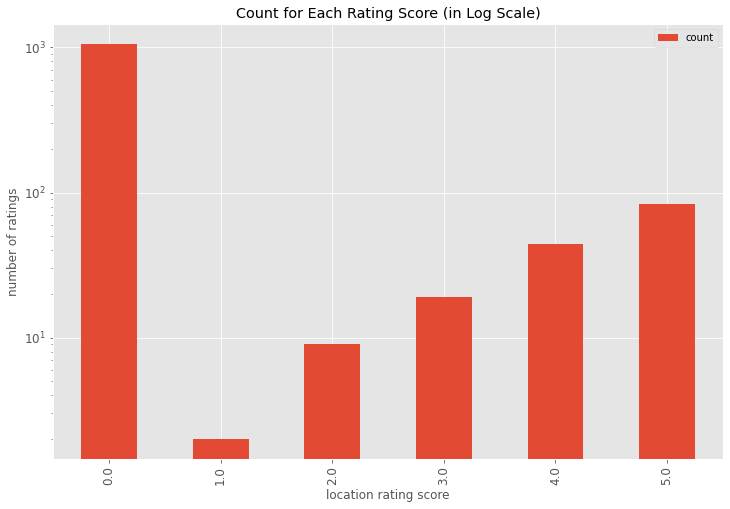

In [20]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("location rating score")
ax.set_ylabel("number of ratings")

In [21]:
# get rating frequency
#number of ratings each location got.
df_location_cnt = pd.DataFrame(df_ratings.groupby('location').size(), columns=['count'])
df_location_cnt.head()



,count
location,
1,11
2,9
3,8
4,7
5,5


In [22]:
#now we need to take only location that have been rated atleast 5 times to get some idea of the reactions of users towards it

popularity_thres = 5
popular_location = list(set(df_location_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_location = df_ratings[df_ratings.location.isin(popular_location)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular location: ', df_ratings_drop_location.shape)



shape of original ratings data:  (157, 3)
shape of ratings data after dropping unpopular location:  (153, 3)


In [23]:

# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_location.groupby('commenter').size(), columns=['count'])
df_users_cnt.head()



,count
commenter,
7,3
8,3
10,2
11,2
12,2


In [24]:
# filter data to come to an approximation of user likings.
ratings_thres = 5
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_location[df_ratings_drop_location.commenter.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (157, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (11, 3)


In [25]:
# pivot and create movie-user matrix
location_user_mat = df_ratings_drop_users.pivot(index='location', columns='commenter', values='rating').fillna(0)
#map movie titles to images
location_to_idx = {
    location: i for i, location in 
    enumerate(list(df_location.set_index('id').loc[location_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
location_user_mat_sparse = csr_matrix(location_user_mat.values)

In [26]:
location_user_mat_sparse

<10x2 sparse matrix of type '<class 'numpy.float32'>'
	with 11 stored elements in Compressed Sparse Row format>

In [27]:
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=10, n_jobs=-1)
# fit
model_knn.fit(location_user_mat_sparse)

NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=10)

In [28]:
from fuzzywuzzy import fuzz

C:\Users\suraj\anaconda3\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [29]:
def fuzzy_matching(mapper, fav_location, verbose=True):
    """
    return the closest match via fuzzy ratio. 
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_location.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]

In [30]:
def make_recommendation(model_knn, data, mapper, fav_location, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_location)
    idx = fuzzy_matching(mapper, fav_location, verbose=True)
    
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_location))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [31]:
location_to_idx

{'Pashupatinath': 0,
 'Kathmandu Durbar square': 1,
 'Boudhanath Stupa': 2,
 'Changunarayan': 3,
 'Swyambunath “The Monkey Temple”': 4,
 'Buddhanilkantha': 5,
 'Sundarijal Hike': 6,
 'Garden of Dreams': 7,
 'Botanical Garden': 8,
 'Kathmandu FunPark': 9}

In [32]:
my_favorite = 'Pashupatinath'

In [33]:
d=make_recommendation(model_knn=model_knn,
    data=location_user_mat_sparse,
     fav_location=my_favorite,
    mapper=location_to_idx,
    n_recommendations=5)

You have input movie: Pashupatinath
Found possible matches in our database: ['Pashupatinath']

Recommendation system start to make inference
......

Recommendations for Pashupatinath:
1: Swyambunath “The Monkey Temple”, with distance of 0.2928932309150696
2: Changunarayan, with distance of 0.0
3: Pashupatinath, with distance of 0.0
4: Botanical Garden, with distance of 0.0
5: Kathmandu FunPark, with distance of 0.0
